In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai tavily-python

In [1]:
import getpass
import os

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("TAVILY_API_KEY")

## Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change they agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [4]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [5]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_amygNUKNRXmKBcvJxhFSiR4R)
 Call ID: call_amygNUKNRXmKBcvJxhFSiR4R
  Args:
    query: LangGraph programming language


So far, all of this is an _exact repeat_ of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool? 

Let's directly provide the correct response!

In [6]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='9a811885-1e84-40ca-bc3a-d815df93218f', tool_call_id='call_amygNUKNRXmKBcvJxhFSiR4R'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='386d5031-b380-4665-9792-b437f6c46c14')]


Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspect the [LangSmith trace](https://smith.langchain.com/public/c45207bb-bd26-4c9a-b631-928bbeebfbcb/r) of the `update_state` call above to see what's going on.

**Notice** that our new messages are _appended_ to the messages already in the state. Remember how we defined the `State` type?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [7]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef36eb3-a391-6640-8003-b8004a00847a'}}

Check out the [LangSmith trace](https://smith.langchain.com/public/ce83989f-6e49-4bdd-bcd5-f54ca55c8d00/r/30b1406a-ae5b-4e9e-9fe5-032be6efb92e) for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

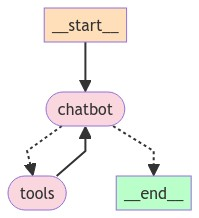

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [9]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='9a811885-1e84-40ca-bc3a-d815df93218f', tool_call_id='call_amygNUKNRXmKBcvJxhFSiR4R'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='386d5031-b380-4665-9792-b437f6c46c14'), AIMessage(content="I'm an AI expert!", id='3d5cd835-ba10-4e4a-8cae-ba0ab65aa367')]
()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

#### What if you want to **overwrite** existing messages? 

The [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) overwrites the existing message with the new content. 

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [10]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yqanteFp9pucJTwLCU6bpa3i)
 Call ID: call_yqanteFp9pucJTwLCU6bpa3i
  Args:
    query: LangGraph overview
  tavily_search_results_json (call_f3erl2xMA4xpEWwqNt5FL9wh)
 Call ID: call_f3erl2xMA4xpEWwqNt5FL9wh
  Args:
    query: LangGraph programming language features
  tavily_search_results_json (call_UQHuaBU5ETyeNzCiNKDAjIra)
 Call ID: call_UQHuaBU5ETyeNzCiNKDAjIra
  Args:
    query: LangGraph use cases


**Next,** let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [11]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-46a87cd6-9b1c-44bb-aeb2-23a5b79241e9-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph overview'}, 'id': 'call_yqanteFp9pucJTwLCU6bpa3i'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_yqanteFp9pucJTwLCU6bpa3i'}
Message ID run-46a87cd6-9b1c-44bb-aeb2-23a5b79241e9-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_yqanteFp9pucJTwLCU6bpa3i'}]

**Notice** that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Check out the [LangSmith trace](https://smith.langchain.com/public/cd7c09a6-758d-41d4-8de1-64ab838b2338/r) to see the state update call - you can see our new message has successfully updated the previous AI message.

Resume the graph by streaming with an input of `None` and the existing config.

In [12]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/how-tos/human-in-the-loop/", "content": "How to add human-in-the-loop. When creating LangGraph agents, it is often nice to add a human-in-the-loop component. This can be helpful when giving them access to tools. Often in these situations you may want to manually approve an action before taking. This can be in several ways, but the primary supported way is to add an \"interrupt\" before ..."}, {"url": "https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/", "content": "When creating LangGraph agents, it is often nice to add a human-in-the-loop component. This can be helpful when giving them access to tools. ... # Build the graph from langgraph.graph import END, StateGraph # Define a new graph workflow = StateGraph (MessagesState) # Define the two nodes we will cycle between workflow. add_node 

Check out the [trace](https://smith.langchain.com/public/2d633326-14ad-4248-a391-2757d01851c4/r/6464f2f2-edb4-4ef3-8f48-ee4e249f2ad0) to see the tool call and later LLM response. **Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

**Congratulations!** You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.